# 02_MARES_mooring_DATA_fromraw
Regrid raw MARES mooring data to hourly means, and convert some vraiables (T, Sp) to more useful forms (CT, Sa)

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

from metpy.calc import wind_components
from metpy.units import units

import gsw
import gsw.freezing

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean


sys.path.append('../../')
import timeseries.despike as despike
import timeseries.adjust as tseries
import timeseries.filter as filters

In [205]:
def filter_around_nans(filtered_val, thresh, numaround = 2):
    
    # numaround = 3 (values around each non-nan point to check for lots of nans)
    
    remove_cts = 0
    
    UNITS = filtered_val.units
    
    # find nans
    yes_nans = np.where(np.isnan(filtered_val.magnitude))[0]
    not_nans = np.where(np.isfinite(filtered_val.magnitude))[0]

    # make copy
    sus_nans = np.copy(filtered_val.magnitude)

    for ii in not_nans:

        yes_nans = np.where(np.isnan(sus_nans))[0]
        not_nans = np.where(np.isfinite(sus_nans))[0]

        # check if lots of nans before
        if np.sum(np.isnan(sus_nans[ii-numaround:ii])) >= numaround:
            
            # find last non-nan index
            if np.sum(not_nans < ii) > 0:
                not_nan_before = not_nans[not_nans < ii].max()

                # see if change across exceeds allowed
                d_value = (sus_nans[ii] - sus_nans[not_nan_before]) * UNITS
                dt_hr = (t[ii] - t[not_nan_before])*units('s').to('h')

                if abs(d_value/dt_hr) > thresh:
                    sus_nans[ii] = np.nan
                    remove_cts+=1

        # check if lots of nans after
        if np.sum(np.isnan(sus_nans[ii:ii+numaround])) >= numaround:

            # find last non-nan index
            if np.sum(not_nans < ii) > 0:
                not_nan_after = not_nans[not_nans > ii].min()

                # see if change across exceeds allowed
                d_value = (sus_nans[ii] - sus_nans[not_nan_after]) * UNITS
                dt_hr = (t[ii] - t[not_nan_after])*units('s').to('h')

                if abs(d_value/dt_hr) > thresh:
                    sus_nans[ii] = np.nan
                    remove_cts+=1
                
    print(f'removed {remove_cts} sus nan values')
    return sus_nans * UNITS

In [2]:
import scipy
from scipy import stats
import scipy.io

In [5]:
# file = '/Users/mackenziejewell/Downloads/M2a/MARES_M2a_Final1.mat'
# mat = scipy.io.loadmat(file)

In [7]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'adcp'])

In [16]:
len(mat['adcp'][0][0][0])

1

In [17]:
mat['adcp'][0][0][0]

array([[(array([[2131]], dtype=uint16), array(['M2a'], dtype='<U3'), array(['MARES'], dtype='<U5'), array([[300]], dtype=uint16), array(['WH_ADCP'], dtype='<U7'), array([[2016,   10,    6,    1,   30,    0]], dtype=uint16), array([[2017,    9,   28,   20,   45,    0]], dtype=uint16), array([[  69.   ,   54.48 , -138.   ,  -59.928]]), array([[30]], dtype=uint8), array([[1]], dtype=uint8), array([[2]], dtype=uint8), array([[1.76]]), array([[4.2]]), array([[2.4]]), array([[50.4]]), array(['up'], dtype='<U2'), array(['413220395'], dtype='<U9'), array([[20]], dtype=uint8), array([[0.1]]), array([[99]], dtype=uint8), array([[2, 3, 5, 8]], dtype=uint8))]],
      dtype=[('sn', 'O'), ('mooringID', 'O'), ('cruiseID', 'O'), ('frequency', 'O'), ('Instrument_name', 'O'), ('time_start', 'O'), ('time_end', 'O'), ('position', 'O'), ('bins', 'O'), ('pings_per_ensemble', 'O'), ('bin_size', 'O'), ('blank', 'O'), ('bin1_dist', 'O'), ('transmit_pulse_length', 'O'), ('ADCP_firmware', 'O'), ('start_orientati

## Open master 2017-2019 mooring data files
Different files for each year and mooring location. For each run, specify file name ("file") and years of the winter to grab data from (e.g. open_years = '2016_2017').

In [202]:
# M1
#--------------------------
# 2017-2019
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/raw/mares-mooring-m1-2017-2019_708f_9959_e0ad.csv'
# open_years = '2017_2018'
# open_years = '2018_2019'

# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/raw/mares-mooring-m1_0786_46bf_f732.csv'
# open_years = '2016_2017'

# M2
#--------------------------
# 2017-2018
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/raw/mares-mooring-m2-2017-2018_4de0_f9b1_cf0a.csv'
# open_years = '2017_2018'

# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/raw/mares-mooring-m2_cdf3_5fa4_3f35.csv'
# open_years = '2016_2017'

# M3
#--------------------------
# 2017-2018
file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/raw/mares-mooring-m3-2017-2018_d596_5d0f_b4ec.csv'
open_years = '2017_2018'
# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/raw/mares-mooring-m3_f38c_239a_cc5b.csv'
# open_years = '2016_2017'

# M4
#--------------------------
# 2017-2018
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/raw/mares-mooring-m4-2017-2018_13a0_8681_05f5.csv'
# open_years = '2017_2018'
# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/raw/mares-mooring-m4_d219_56a0_28df.csv'
# open_years = '2016_2017'

# determine which mooring
M = file.split('MARES_moorings/')[1].split('/')[0]
print(f'mooring {M}')


df = pd.read_csv(file,skiprows=[0])
UNITS  = df.columns.values
df = pd.read_csv(file,skiprows=[1])

# currents are every 20 minutes

cats = list(df.columns)
# units = list(df.columns)
for cat, unit in zip(cats, UNITS):
    print(f'{cat} [{unit}]')

pd_times = np.array([datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ') for date in df.time.values])
df['time'] = pd_times
# df.sea_water_speed

depths = np.sort(np.array(list(set(df.z.values))))


print(f"\ntime: {df['time'].values[0]} - {df['time'].values[-1]}")
print(f"\ndepths: {depths}")

mooring M3
time [UTC]
latitude [degrees_north]
longitude [degrees_east]
z [m]
sea_water_velocity_to_direction [degrees]
sea_water_velocity_to_direction_qc_agg [Unnamed: 5]
sea_water_speed [m.s-1]
sea_water_speed_qc_agg [Unnamed: 7]
sea_water_practical_salinity [1e-3]
sea_water_practical_salinity_qc_agg [Unnamed: 9]
eastward_sea_ice_velocity [m.s-1.1]
eastward_sea_ice_velocity_qc_agg [Unnamed: 11]
northward_sea_ice_velocity [m.s-1.2]
northward_sea_ice_velocity_qc_agg [Unnamed: 13]
sea_water_temperature [degree_Celsius]
sea_water_temperature_qc_agg [Unnamed: 15]

time: 2017-10-02T21:00:01.000000000 - 2018-10-10T22:15:39.000000000

depths: [-263. -252. -247. -231. -215. -199. -192. -183. -167. -151. -135. -132.
 -119. -103.  -87.  -71.  -55.  -52.  -39.    0.]


# (A) Grab 60-minute sea ice velocity data

### (1) Find which current depths have many reported values (Depends on each variable)

In [4]:
current_depths = np.array([])

for depth in depths:
    
    var = 'eastward_sea_ice_velocity'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)

0.0: # obs = 24315


In [5]:
depth = 0 

In [6]:
# grab currents and sea ice velocity
U = df.eastward_sea_ice_velocity.values
V = df.northward_sea_ice_velocity.values

# grab all times
times = df.time[df.z == depth].values
u_vals = U[df.z == depth]
v_vals = V[df.z == depth]

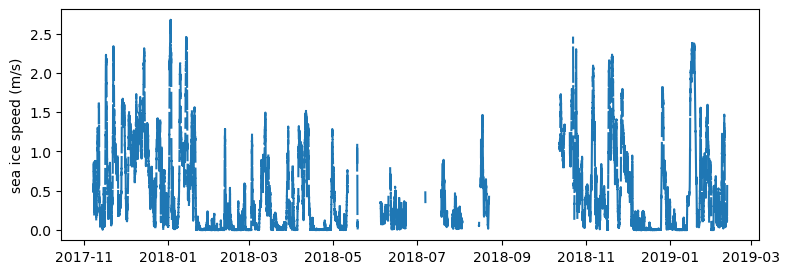

In [9]:

fig, ax = plt.subplots(figsize=(9,3))
plt.plot(times, np.sqrt(u_vals**2+v_vals**2))
ax.set_ylabel('sea ice speed (m/s)')
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

### (2) Find hourly means

In [147]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['u'] = np.full(len(spec_dates), np.nan)
    interp[depth]['v'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab currents and sea ice velocity
    U = df.eastward_sea_ice_velocity.values
    V = df.northward_sea_ice_velocity.values

    # grab all times
    times = df.time[df.z == depth].values
    u_vals = U[df.z == depth]
    v_vals = V[df.z == depth]
    
    # grab times as seconds elapsed
    t = tseries.seconds_elapsed(times)
    tls = tseries.seconds_elapsed(spec_dates, t0 = times[0])
    
    # filter velocities, first flagging unrealistic accelerations
    # and then with a 3sigma / median filter
    thresh = 100 * units('cm/s') / units('hour')
    out = despike.flag_accelerations(times, u_vals*units('m/s'), v_vals*units('m/s'), 
                                     thresh = thresh)
    ac, filter_u, filter_v = out
    filt_u = despike.sigma3filter(times, filter_u.magnitude, L=timedelta(hours=6), N=3)
    filt_v = despike.sigma3filter(times, filter_v.magnitude, L=timedelta(hours=6), N=3)

    # loess filter to grab data at specified time stamps
    tau = (60 * 60) * 3
    uls, uflag = filters.loess(filt_u, t, tls, tau)
    vls, vflag = filters.loess(filt_v, t, tls, tau)

    # replace flagged values with nan
    uls[uflag+vflag] = np.nan
    vls[uflag+vflag] = np.nan

    interp[depth]['u'] = uls
    interp[depth]['v'] = vls
        
#     for dd, date in enumerate(spec_dates):

#         # time diff in units of xx-min increments
#         tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
#         tdiff = tdiff_seconds / sample_rate

#         # find those within sample_rate seconds up to nearest time
#         time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]

#         if len(time_ind) > 0:
#             interp[depth]['obs'][dd] = np.sum(np.isfinite(uls[time_ind]))
#             interp[depth]['u'][dd] = np.nanmean(uls[time_ind])
#             interp[depth]['v'][dd] = np.nanmean(vls[time_ind])
            

            
# REGRID THE DATA
#----------------
all_u = np.array([])
all_v = np.array([])

for depth in current_depths:
    all_u = np.append(all_u, interp[depth]['u'])
    all_v = np.append(all_v, interp[depth]['v'])
    
u_grid = np.reshape(all_u, (len(current_depths), len(spec_dates)))
v_grid = np.reshape(all_v, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


### (3) Save to netCDF

In [148]:
ds = xr.Dataset({"u": (("depth", "time"), u_grid, {'long_name':'eastward velocity', 'units':'m/s'}),
                 "v": (("depth", "time"), v_grid, {'long_name':'northward velocity', 'units':'m/s'})},
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})

# mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
# filename = f"{M}/{M}_hourly_seaice_velocity_{open_years}.nc"
# ds.to_netcdf(mainpath+filename)

<IPython.core.display.Javascript object>


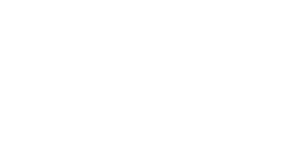

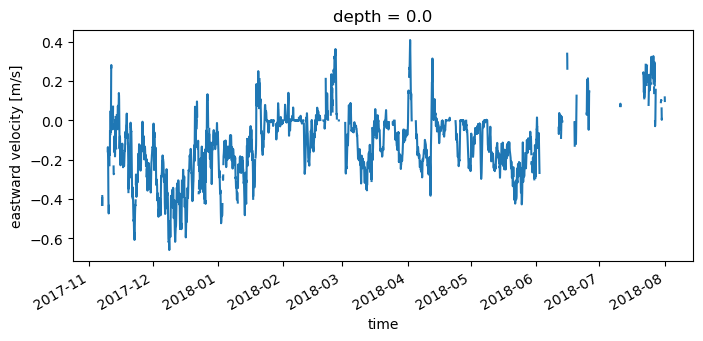

In [149]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,3))
ds.u.plot()

# (B) Grab 60-minute current data

### (1) Find which current depths have many reported values (Depends on each variable)

In [150]:
current_depths = np.array([])

for depth in depths:
    
    if 'eastward_sea_water_velocity' in cats:
        var = 'eastward_sea_water_velocity'
    else:
        var = 'sea_water_speed'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)


-310.0: # obs = 26858
-294.0: # obs = 26858
-278.0: # obs = 26858
-262.0: # obs = 26858
-246.0: # obs = 26848
-230.0: # obs = 26831
-214.0: # obs = 26811
-198.0: # obs = 26784
-182.0: # obs = 26753
-166.0: # obs = 26607
-150.0: # obs = 25985
-134.0: # obs = 25181
-118.0: # obs = 24564
-102.0: # obs = 23850
-86.0: # obs = 23230
-70.0: # obs = 23404


### (2) Find hourly means

In [151]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['u'] = np.full(len(spec_dates), np.nan)
    interp[depth]['v'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab currents and sea ice velocity

    if 'eastward_sea_water_velocity' in cats:
        
        # no need to convert for others
        #-----------------------------------
        U = df.eastward_sea_water_velocity.values
        V = df.northward_sea_water_velocity.values
        
    else:
        # need to convert for some years, moorings
        #--------------------------------
        # direction indicates the direction towards which the velocity vector of X is headed. 
        # The direction is a bearing in the usual geographical sense, measured positive clockwise from due north.
        directions = df.sea_water_velocity_to_direction.values
        speeds = df.sea_water_speed.values

        # transform from bearing to x - eastward and y - northward
        (u, v) = wind_components(speeds * units('m/s'), directions * units.deg)
        U = -u.magnitude
        V = -v.magnitude


    # grab all times
    times = df.time[df.z == depth].values
    u_vals = U[df.z == depth]
    v_vals = V[df.z == depth]
    
    # grab times as seconds elapsed
    t = tseries.seconds_elapsed(times)
    tls = tseries.seconds_elapsed(spec_dates, t0 = times[0])
    
    # filter velocities, first flagging unrealistic accelerations
    # and then with a 3sigma / median filter
    thresh = 100 * units('cm/s') / units('hour')
    out = despike.flag_accelerations(times, u_vals*units('m/s'), v_vals*units('m/s'), 
                                     thresh = thresh)
    ac, filter_u, filter_v = out
    filt_u = despike.sigma3filter(times, filter_u.magnitude, L=timedelta(hours=6), N=3)
    filt_v = despike.sigma3filter(times, filter_v.magnitude, L=timedelta(hours=6), N=3)

    # loess filter to grab data at specified time stamps
    tau = (60 * 60) * 3
    uls, uflag = filters.loess(filt_u, t, tls, tau)
    vls, vflag = filters.loess(filt_v, t, tls, tau)

    # replace flagged values with nan
    uls[uflag+vflag] = np.nan
    vls[uflag+vflag] = np.nan

    interp[depth]['u'] = uls
    interp[depth]['v'] = vls
    
    
#     for dd, date in enumerate(spec_dates):

#         # time diff in units of xx-min increments
#         tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
#         tdiff = tdiff_seconds / sample_rate

#         # find those within sample_rate seconds up to nearest time
#         time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]

#         if len(time_ind) > 0:
#             interp[depth]['obs'][dd] = np.sum(np.isfinite(u_vals[time_ind]))
#             interp[depth]['u'][dd] = np.nanmean(u_vals[time_ind])
#             interp[depth]['v'][dd] = np.nanmean(v_vals[time_ind])
            
# REGRID THE DATA
#----------------
all_u = np.array([])
all_v = np.array([])

for depth in current_depths:
    all_u = np.append(all_u, interp[depth]['u'])
    all_v = np.append(all_v, interp[depth]['v'])
    
u_grid = np.reshape(all_u, (len(current_depths), len(spec_dates)))
v_grid = np.reshape(all_v, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


### (3) Save to netCDF

In [152]:
ds = xr.Dataset({"u": (("depth", "time"), u_grid, {'long_name':'eastward velocity', 'units':'m/s'}),
                 "v": (("depth", "time"), v_grid, {'long_name':'northward velocity', 'units':'m/s'})},
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})

# mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
# filename = f"{M}/{M}_hourly_ocean_currents_{open_years}.nc"
# ds.to_netcdf(mainpath+filename)


# (C) Grab 60-minute Temperature, Salinity data

### (1) Find which current depths have many reported values (Depends on each variable)

In [203]:
current_depths = np.array([])

for depth in depths:
    
    var = 'sea_water_temperature'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)

-252.0: # obs = 35814
-192.0: # obs = 35814
-132.0: # obs = 35814
-52.0: # obs = 35812


### (2) Find hourly means

In [206]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['T'] = np.full(len(spec_dates), np.nan)
    interp[depth]['S'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab temperature and salinity
    T = df.sea_water_temperature.values
    S = df.sea_water_practical_salinity.values

    # grab all times
    times = df.time[df.z == depth].values
    T_vals = T[df.z == depth]
    S_vals = S[df.z == depth]
    
    # flag unrealtistic vals
#     S_vals[S_vals<28] = np.nan
    
    # grab times as seconds elapsed
    t = tseries.seconds_elapsed(times)
    tls = tseries.seconds_elapsed(spec_dates, t0 = times[0])
    
    # filter velocities, first flagging unrealistic accelerations
    # and then with a 3sigma / median filter
    thresh = 1 * units('delta_degC') / units('hour')
    dv, filter_T = despike.flag_timechanges(times, T_vals*units('delta_degC'), thresh = thresh)
    
    # filter around nans
    filter_T = filter_around_nans(filter_T, 0.5*thresh, numaround = 3)
    
    thresh = 0.5 * units('m') / units('hour') # arbitrary units, but should match Sa units per hour
    dv, filter_S = despike.flag_timechanges(times, S_vals*units('m'), thresh = thresh)
    
    # filter around nans
    filter_S = filter_around_nans(filter_S, 0.5*thresh, numaround = 3)

    # loess filter to grab data at specified time stamps
    tau = (60 * 60) * 3
    Tls, Tflag = filters.loess(filter_T.magnitude, t, tls, tau)
    Sls, Sflag = filters.loess(filter_S.magnitude, t, tls, tau)

    # replace flagged values with nan
    Tls[Tflag+Sflag] = np.nan
    Sls[Tflag+Sflag] = np.nan

    interp[depth]['T'] = Tls
    interp[depth]['S'] = Sls

#     for dd, date in enumerate(spec_dates):

#         # time diff in units of xx-min increments
#         tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
#         tdiff = tdiff_seconds / sample_rate

#         # find those within sample_rate seconds up to nearest time
#         time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]
        
#         if len(time_ind) > 0:
#             interp[depth]['obs'][dd] = np.sum(np.isfinite(T_vals[time_ind]))
#             interp[depth]['T'][dd] = np.nanmean(T_vals[time_ind])
#             interp[depth]['S'][dd] = np.nanmean(S_vals[time_ind])
            
            
# REGRID THE DATA
#----------------
all_T = np.array([])
all_S = np.array([])

for depth in current_depths:
    all_T = np.append(all_T, interp[depth]['T'])
    all_S = np.append(all_S, interp[depth]['S'])
    
T_grid = np.reshape(all_T, (len(current_depths), len(spec_dates)))
S_grid = np.reshape(all_S, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


removed 0 sus nan values
removed 0 sus nan values
removed 0 sus nan values
removed 0 sus nan values
removed 0 sus nan values
removed 0 sus nan values
removed 13 sus nan values
removed 11 sus nan values


In [184]:
depth = -50

interp[depth] = {}
interp[depth]['T'] = np.full(len(spec_dates), np.nan)
interp[depth]['S'] = np.full(len(spec_dates), np.nan)
interp[depth]['obs'] = np.full(len(spec_dates), np.nan)

# grab temperature and salinity
T = df.sea_water_temperature.values
S = df.sea_water_practical_salinity.values

# grab all times
times = df.time[df.z == depth].values
T_vals = T[df.z == depth]
S_vals = S[df.z == depth]


<IPython.core.display.Javascript object>


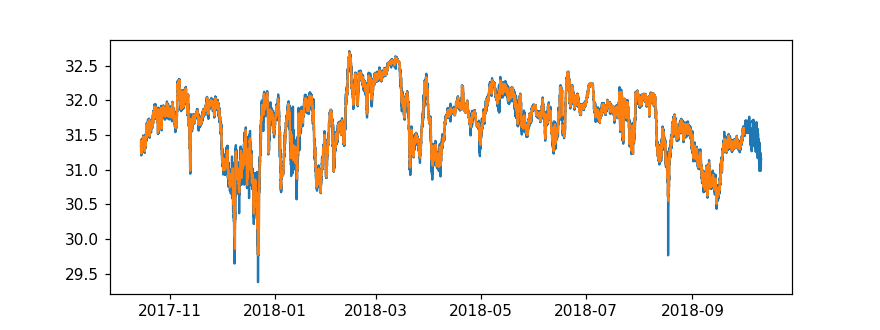

In [207]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(times, S_vals)
# plt.plot(times, filter_S)
# plt.plot(spec_dates, Sls)
# plt.plot(spec_dates, S_grid[0,:])
# plt.plot(times, T_vals)
plt.plot(spec_dates, S_grid[3,:])
# plt.plot(times, filter_T)

# plt.plot(times, sus_nans)



### (3) Convert T, S to more useful forms

In [208]:


# grab coordinates
lat = df.latitude.values[0]
lon = df.longitude.values[0]

def calc_vars_from_T_S(T, SP, depth, lon, lat, saturation_fraction = 1):
    
    # sea pressure ( i.e. absolute pressure - 10.1325 dbar )
    p = gsw.conversions.p_from_z(depth, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    # Absolute Salinity (g / kg)
    SA = gsw.conversions.SA_from_SP(SP, p, lon, lat)

    # Conservative Temperature (ITS-90) (degC)
    CT = gsw.conversions.CT_from_t(SA, T, p)

    # Saturation fraction of dissolved air in seawater. (0..1)
    # let's assume its 1?
#     saturation_fraction = 1
    
    # freezing point of water
    T_f = gsw.freezing.CT_freezing(SA, p, saturation_fraction)

    # potential density
    sigma0 = gsw.density.sigma0(SA, CT)
    
    return SA, CT, sigma0, T_f, p


Sa, Ct, r0, Tf, p = calc_vars_from_T_S(T_grid, S_grid, depth_grid, lon, lat, saturation_fraction = 1)


# stability
N2_, pmid_ = gsw.stability.Nsquared(Sa[::-1,:], Ct[::-1,:], p[::-1,:], lat=lat, axis=0)
N2 = N2_[::-1, :]
pmid = pmid_[::-1, :]

In [188]:
# %matplotlib notebook
# fig, ax = plt.subplots(figsize=(10,3))
# plt.pcolormesh(N2, vmin=-0.005, vmax = 0.005, cmap=cmocean.cm.balance)

### (4) Save to netCDF

In [209]:
ds = xr.Dataset({"T": (("depth", "time"), T_grid, {'long_name':'temperature', 'units':'degC'}),
                 "Sp": (("depth", "time"), S_grid, {'long_name':'Practical salinity', 'units':'psu'}),
                 "Sa": (("depth", "time"), Sa, {'long_name':'Absolute salinity','units':'g/kg'}),
                 "Ct": (("depth", "time"), Ct, {'long_name':'Conservative temperature','units':'degC'}),
                 "Tf": (("depth", "time"), Tf, {'long_name':'Freezing temperature','units':'degC'}),
                  "sig0": (("depth", "time"), r0, {'long_name':'Potential density anomaly (pd @0dbar minus 1000 kg/m^3)','units':'kg/m^3'}),
                },
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})


mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
filename = f"{M}/{M}_hourly_tempsalinity_{open_years}.nc"
ds.to_netcdf(mainpath+filename)


# ds = xr.Dataset({"T": (("depth", "time"), T_grid),
#                  "S": (("depth", "time"), S_grid)},
#                 coords={"depth": current_depths,
#                         "time": spec_dates},
#                attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})
